In [ ]:
import torch
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from torch import nn
from torchvision import transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import random
torch.manual_seed(17)

In [ ]:
mnist_dataset = datasets.MNIST(root='./data' , train='True', download='False', transform=ToTensor())

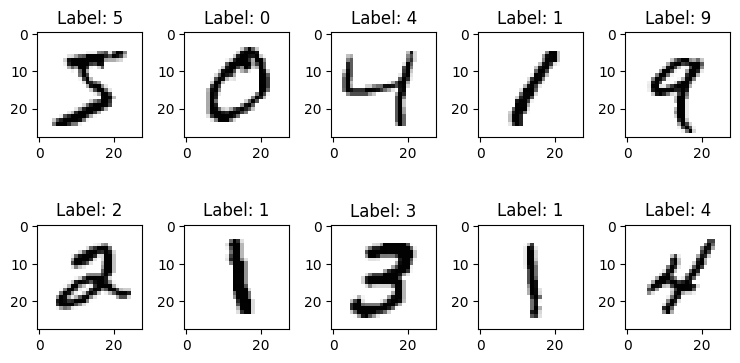

In [ ]:
def plot_set_images(n_row, n_col, images, labels, label_text="Label: "):
  num=len(images)
  num_row=n_row
  num_col=n_col
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i in range(num):
      ax = axes[i//num_col, i%num_col]
      ax.imshow(images[i].reshape(28, 28), cmap='gray_r')
      ax.set_title('{}{}'.format(label_text, labels[i]))
  plt.tight_layout()
  plt.show()

images_set = []
labels_set = []
for i in range(10):
  images_set.append(mnist_dataset[i][0])
  labels_set.append(mnist_dataset[i][1])
plot_set_images(2, 5, images_set, labels_set, "Label: ")

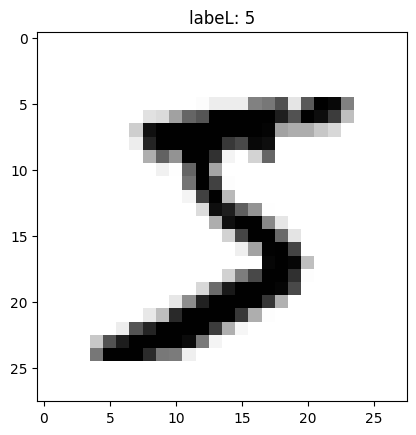

In [ ]:
def plot_image(image, label): 
  plt.imshow(image.reshape(28, 28), cmap="gray_r")
  plt.title("labeL: {}".format(label))

plot_image(mnist_dataset[0][0], mnist_dataset[0][1])

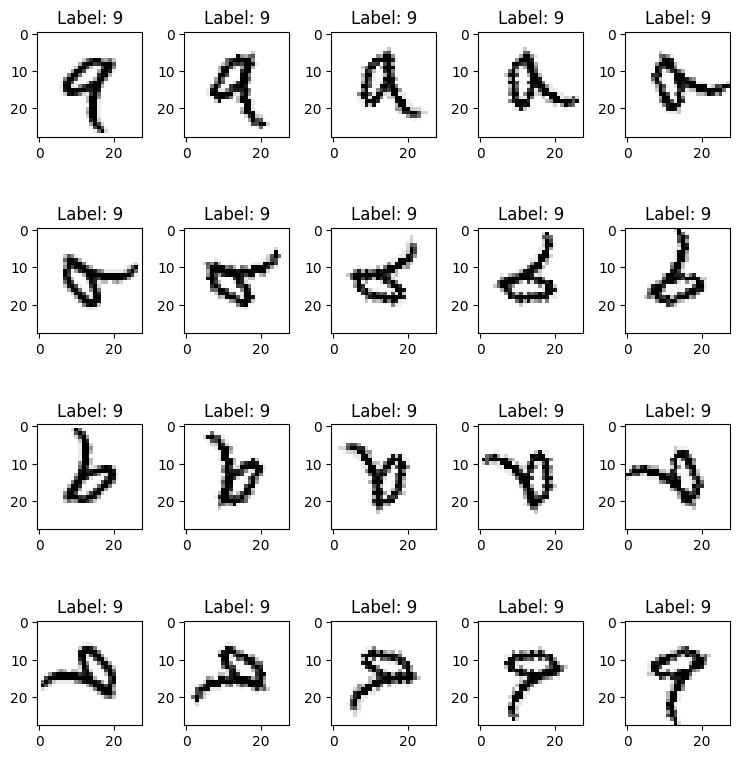

In [ ]:
def rotation(x, angle):
  return TF.rotate(x, angle)

n = 20
image = mnist_dataset[4][0] 
rotated_images=[]
labels = [mnist_dataset[4][1] for i in range(n)]
for i in range(n): 
  r_image = rotation(image, 18*i)
  rotated_images.append(r_image)

plot_set_images(4, 5, rotated_images, labels)

In [ ]:
!git clone https://github.com/gregversteeg/NPEET.git
!pip install NPEET/.

fatal: destination path 'NPEET' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./NPEET
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for NPEET: filename=NPEET-1.0.1-py3-none-any.whl size=7368 sha256=d33af8e89787cdb3a485d387b434736c063a6fcfb3fb1d020faa16ac05b1d2eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-pkrtx9vc/wheels/d8/ef/c5/1da0b424250bc41ab0bbe1bc6a497436fc06c5694a29c92cc2
Successfully built NPEET
  Attempting uninstall: NPEET
    Found existing installation: NPEET 1.0.1
    Uninstalling NPEET-1.0.1:
      Successfully uninstalled NPEET-1.0.1


In [ ]:
from npeet import entropy_estimators as ee

def mutual_info_calculator(image1, image2):
  return ee.mi(image1, image2)



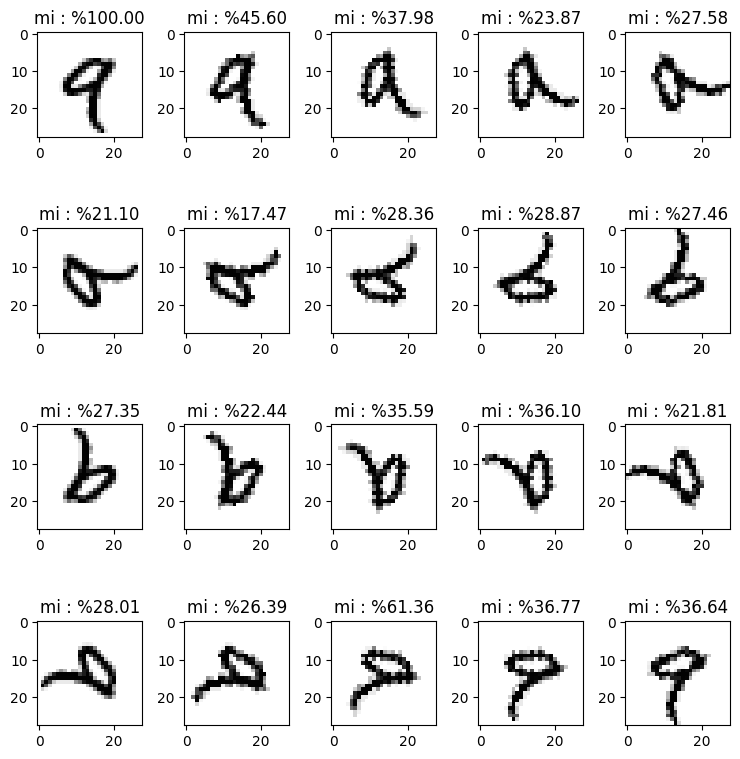

In [ ]:
mutual_informations = []
clean_data_mi = mutual_info_calculator(rotated_images[0].numpy().reshape(28, 28).tolist(), rotated_images[0].numpy().reshape(28, 28).tolist())
mutual_informations.append(clean_data_mi/clean_data_mi*100)
for i in range(1, len(rotated_images)):
  mutual_informations.append(mutual_info_calculator(rotated_images[0].numpy().reshape(28, 28).tolist(), rotated_images[i].numpy().reshape(28, 28).tolist())/clean_data_mi*100.)

mutual_info = ["{:.2f}".format(y) for y in mutual_informations]
plot_set_images(4, 5, rotated_images, mutual_info, "mi : %")

In [ ]:
from torchvision import transforms

test_policy = transforms.Compose([ 
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop((random.randint(14, 28), random.randint(14, 28)), scale=(0.4, 0.9)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.1306], std=[0.3081]),
                transforms.RandomErasing(p=0.2),
                transforms.Resize(size=(28,28)),
            ])

In [ ]:
from torchvision.transforms.autoaugment import AutoAugmentPolicy

torch.manual_seed(38)
auto_aug_policy = transforms.Compose([
                    transforms.AutoAugment(AutoAugmentPolicy.CIFAR10),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.1306], std=[0.3081])
                ])

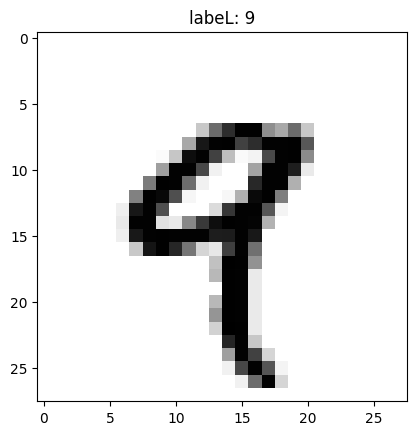

In [ ]:
clean_image = mnist_dataset[4][0] 
plot_image(image, 9)

In [ ]:
def policy_based_augmentation(clean_image, policy):
  n=20
  trans_t2PIL = transforms.ToPILImage()
  image = trans_t2PIL(clean_image)
  augmented_images = []
  augmented_images.append(clean_image)
  for i in range(1, n):
    augmented_images.append(policy(image))
  

  base = mutual_info_calculator(clean_image.numpy().reshape(28, 28).tolist(), clean_image.numpy().reshape(28, 28).tolist()) 
  mutual_info = []
  for i in range(n):
    if i != 0:
      mutual_info.append(mutual_info_calculator(clean_image.numpy().reshape(28, 28).tolist(), augmented_images[i].numpy().reshape(28, 28).tolist())/base*100)
    else:
      mutual_info.append(base/base*100)

  return mutual_info, augmented_images

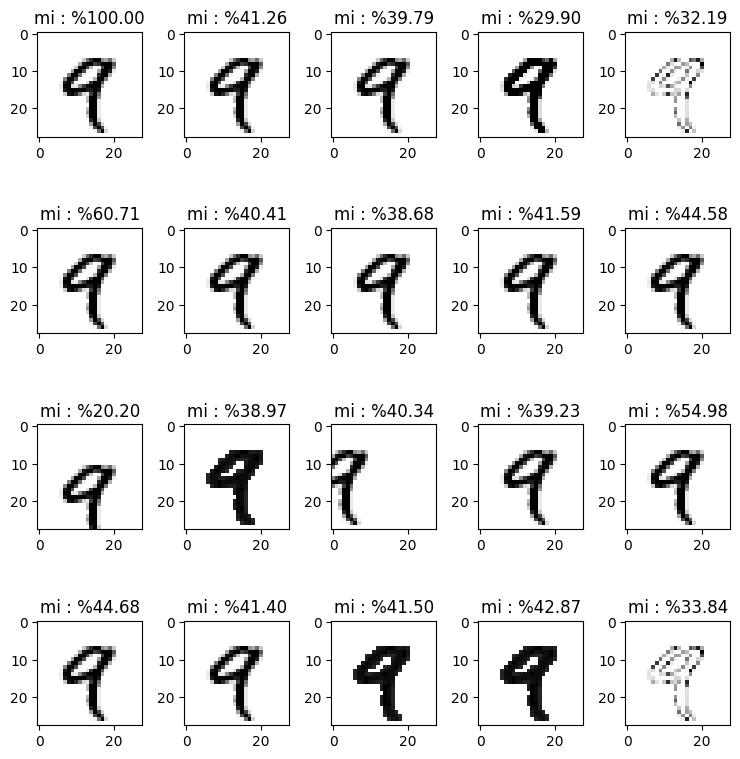

In [ ]:
mi, ai = policy_based_augmentation(clean_image, auto_aug_policy)
mi = ["{:.2f}".format(y) for y in mi]
plot_set_images(4, 5, ai, mi, "mi : %")

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


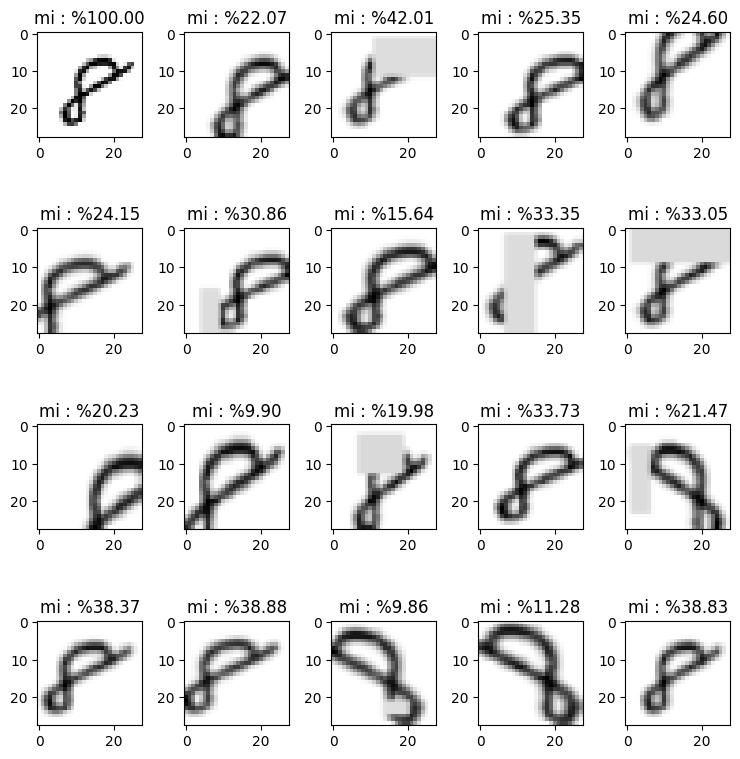

In [ ]:
mi, ai = policy_based_augmentation(clean_image, test_policy)
mi = ["{:.2f}".format(y) for y in mi]
plot_set_images(4, 5, ai, mi, "mi : %")

In [ ]:
def mi_over_dataset_policy_based_calculator(policy = auto_aug_policy):
  average_mutual_infos = np.zeros(len(mnist_dataset))
  aug_images = []
  rnd_mi = []
  j=0

  for i in tqdm(range(len(mnist_dataset))):
    clean_image = mnist_dataset[i][0]
    mi, ai = policy_based_augmentation(clean_image, policy)
    average_mi = np.mean(np.array(mi[1:]))
    average_mutual_infos[i] = average_mi

    if(i == 6000*j):
      k =  random.randint(0, 100)

    if(i==6000*j+k):
      aug_images.append(ai)
      rnd_mi.append(mi)
      j += 1

  return aug_images, rnd_mi, average_mutual_infos


In [ ]:
aug_images, rnd_mi, average_mutual_infos =  mi_over_dataset_policy_based_calculator(auto_aug_policy)

100%|██████████| 60000/60000 [34:17<00:00, 29.16it/s]


In [ ]:
average_mutual_infos.tofile("average_mi_array")
average_mutual_infos = np.fromfile("average_mi_array")
overall_average_mi = np.mean(average_mutual_infos)
print(overall_average_mi)

25.99197678304284


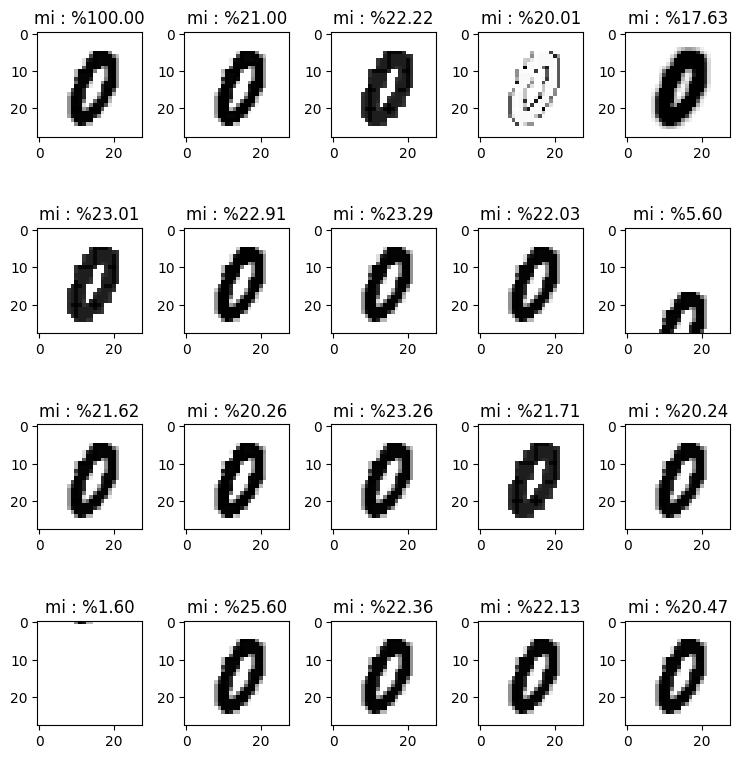


---------------------------------------------------------------------------------------------



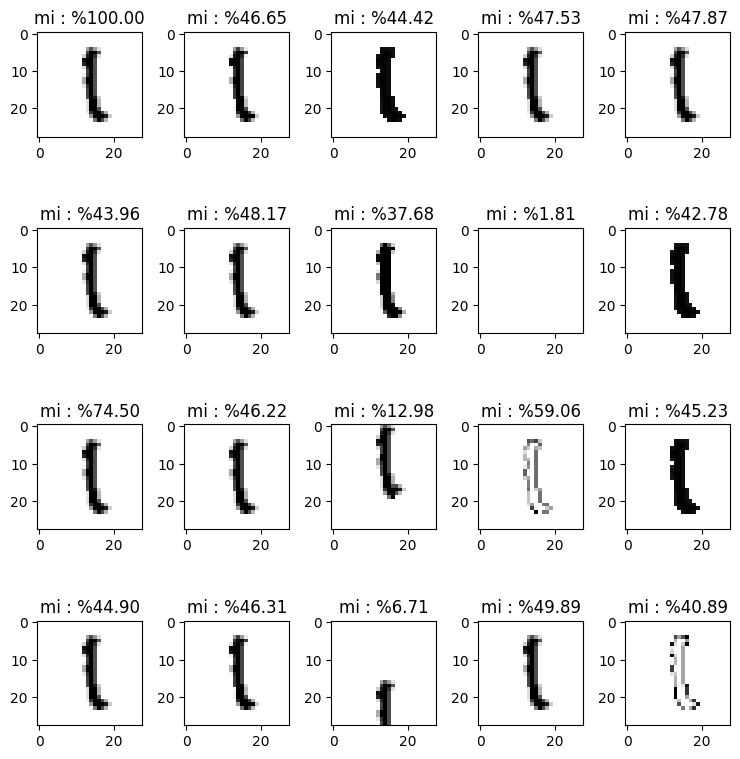


---------------------------------------------------------------------------------------------



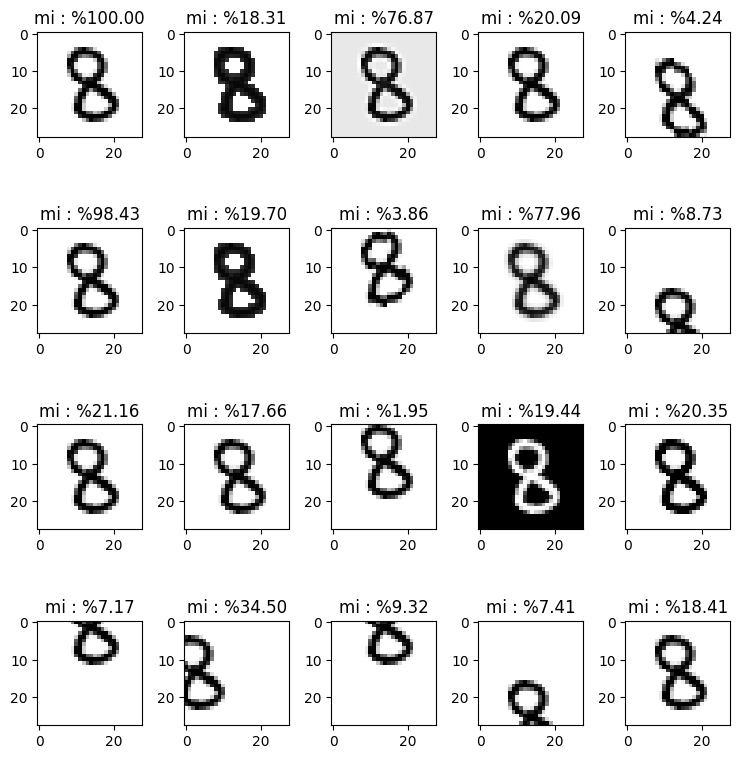


---------------------------------------------------------------------------------------------



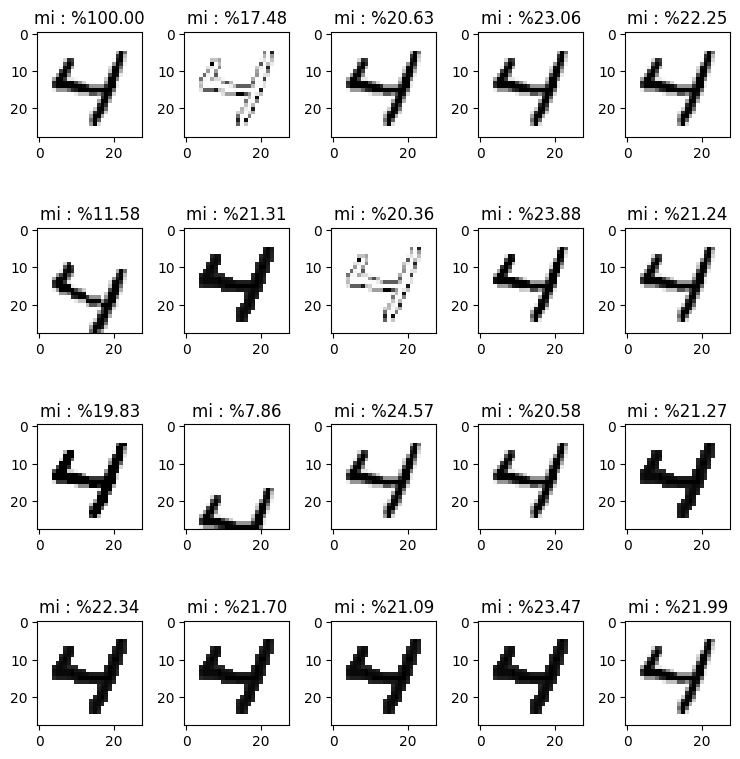


---------------------------------------------------------------------------------------------



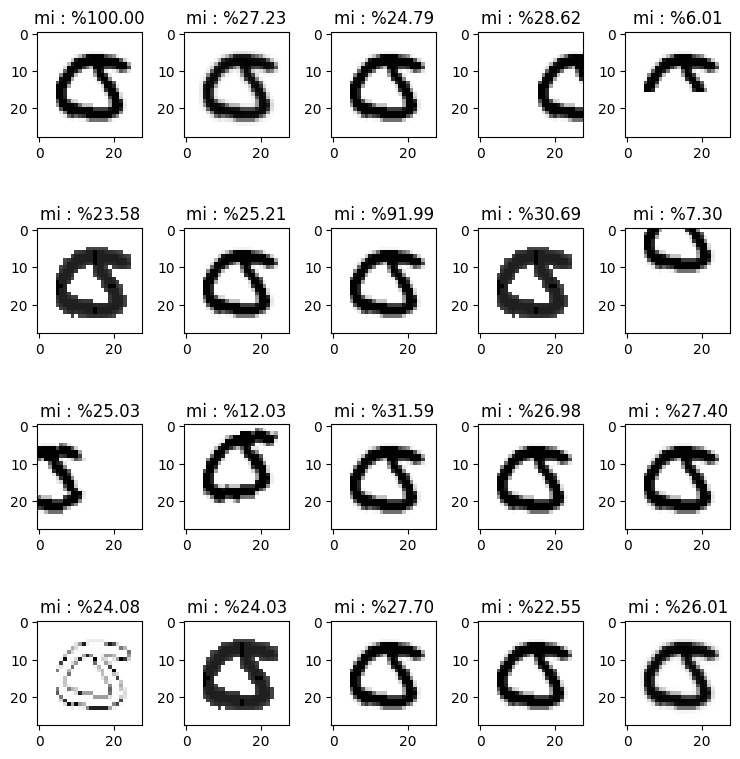


---------------------------------------------------------------------------------------------



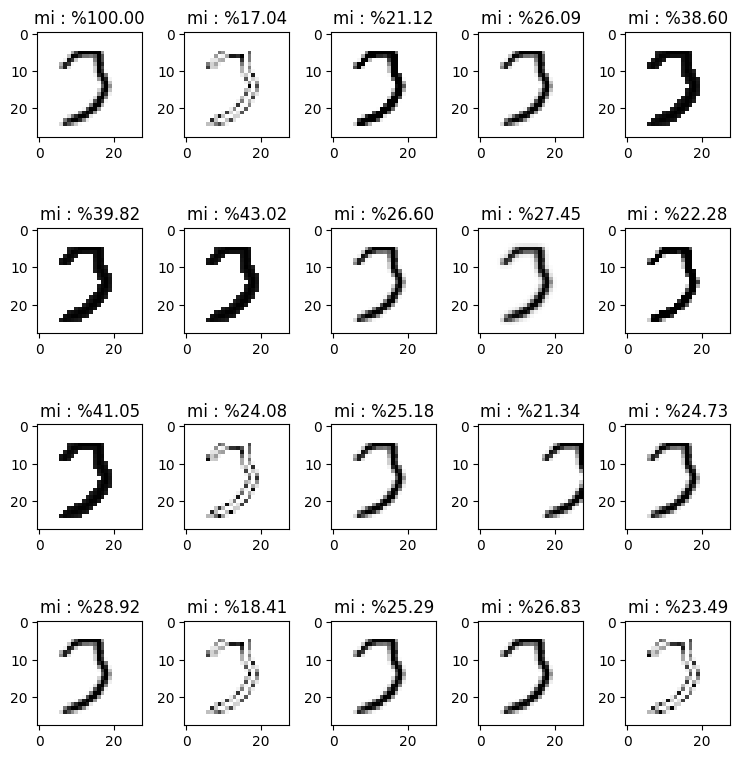


---------------------------------------------------------------------------------------------



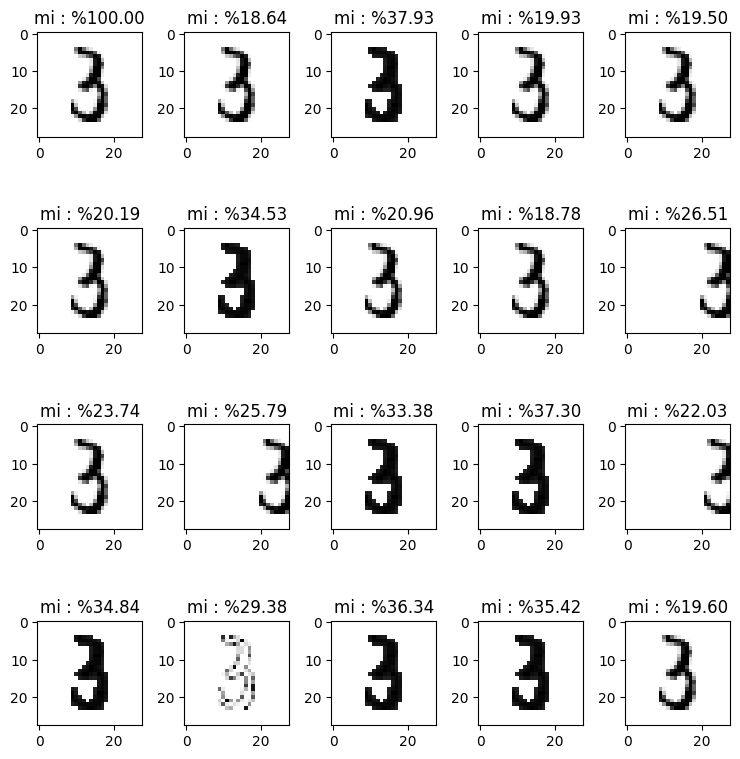


---------------------------------------------------------------------------------------------



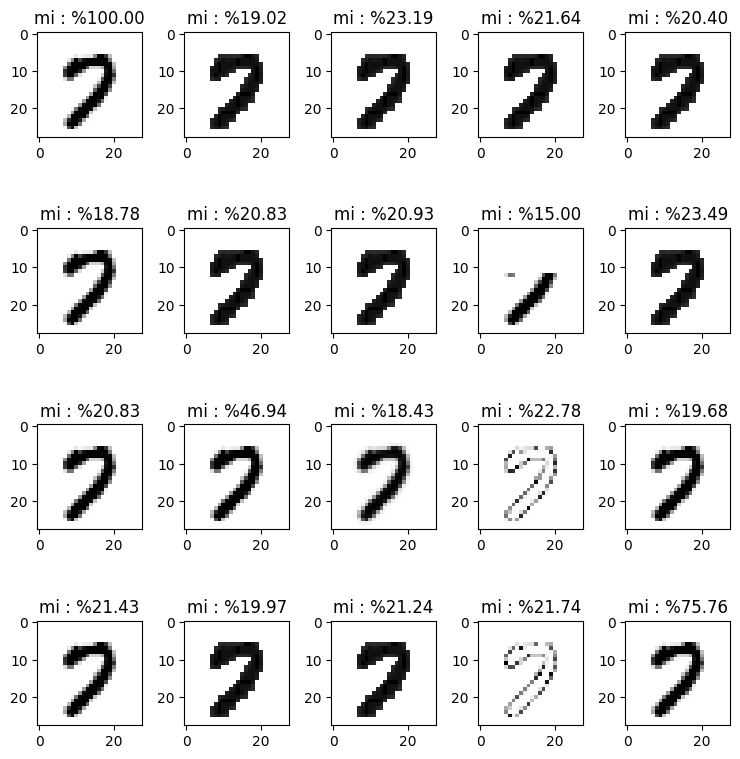


---------------------------------------------------------------------------------------------



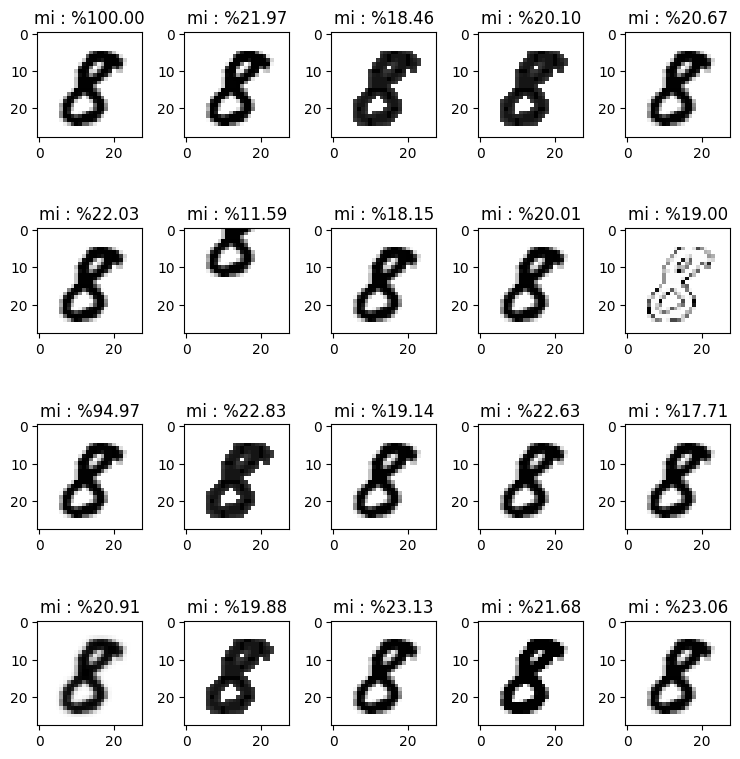


---------------------------------------------------------------------------------------------



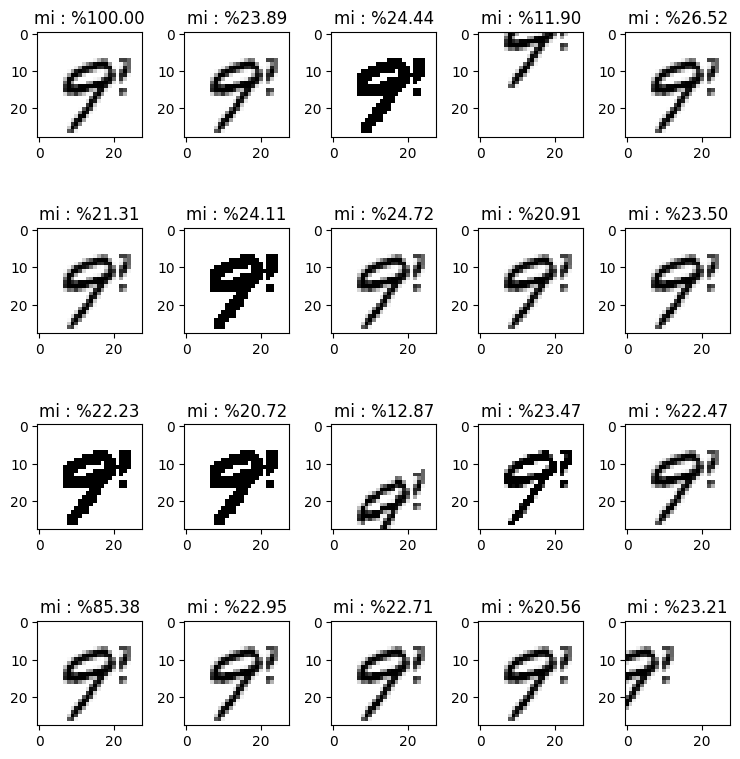


---------------------------------------------------------------------------------------------



In [ ]:
for i in range(len(aug_images)):
  mi = ["{:.2f}".format(y) for y in rnd_mi[i]]
  plot_set_images(4, 5, aug_images[i], mi, "mi : %")
  print()
  print("---------------------------------------------------------------------------------------------")
  print()

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
test_aug_images, test_rnd_mi, test_average_mutual_infos2 = mi_over_dataset_policy_based_calculator(test_policy)

In [ ]:
test_average_mutual_infos2.tofile("test_average_mi_array")
test_average_mutual_infos = np.fromfile("test_average_mi_array")
test_overall_average_mi = np.mean(test_average_mutual_infos)
print(test_overall_average_mi)

22.654506220565658


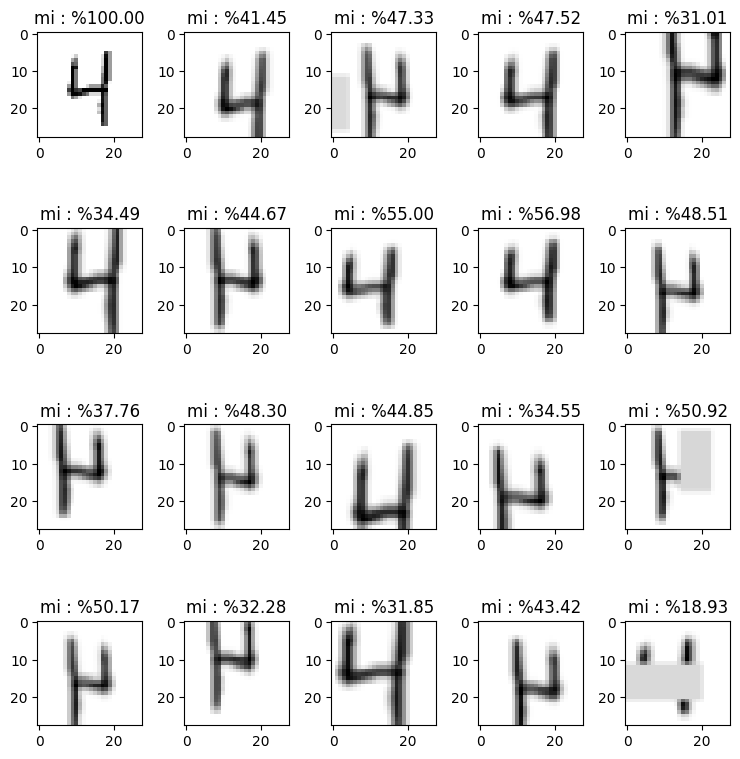


---------------------------------------------------------------------------------------------



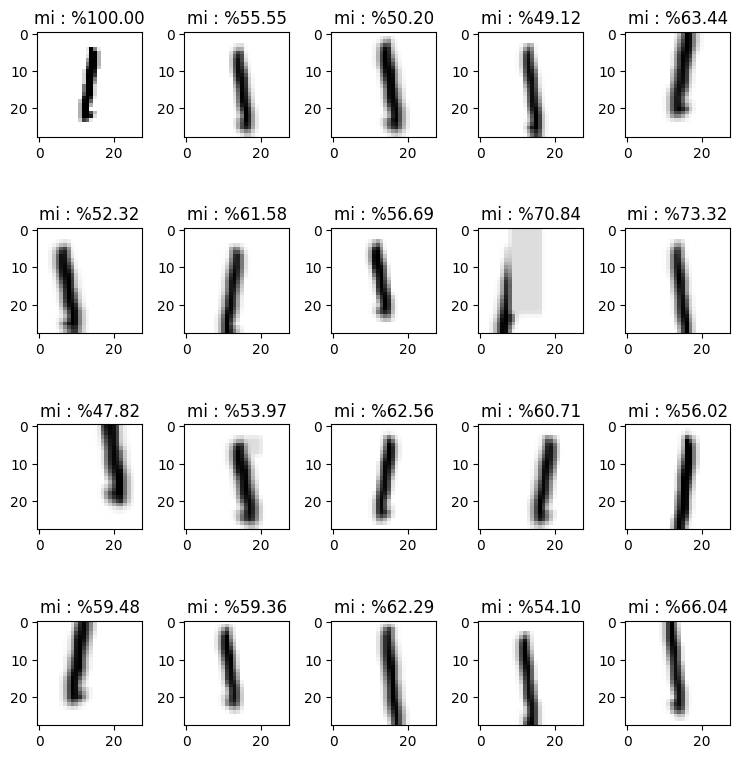


---------------------------------------------------------------------------------------------



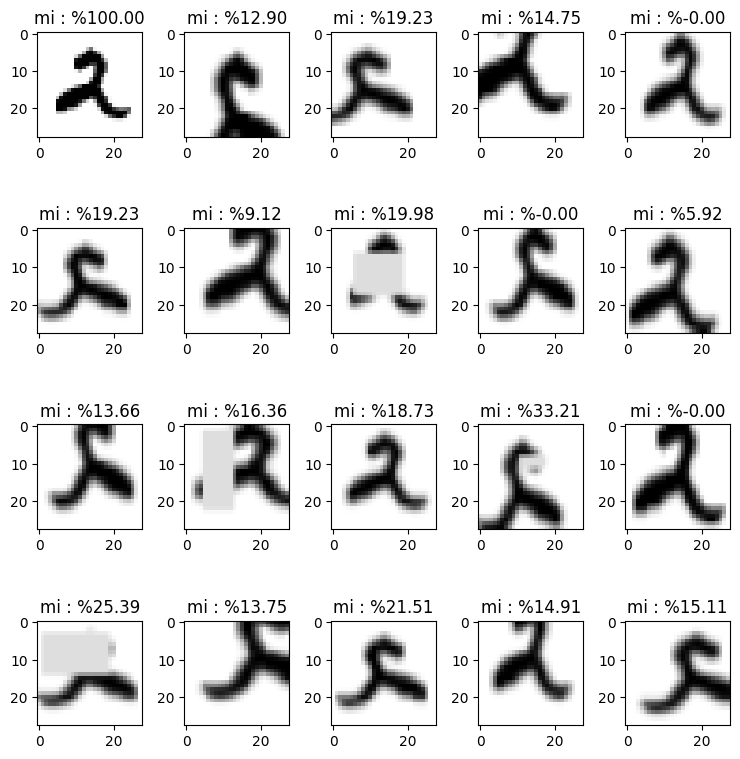


---------------------------------------------------------------------------------------------



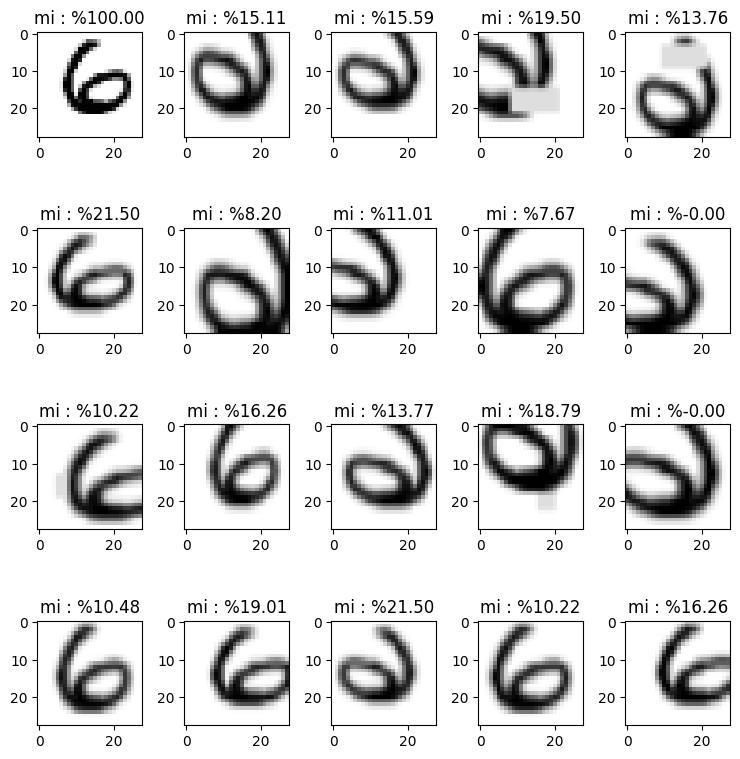


---------------------------------------------------------------------------------------------



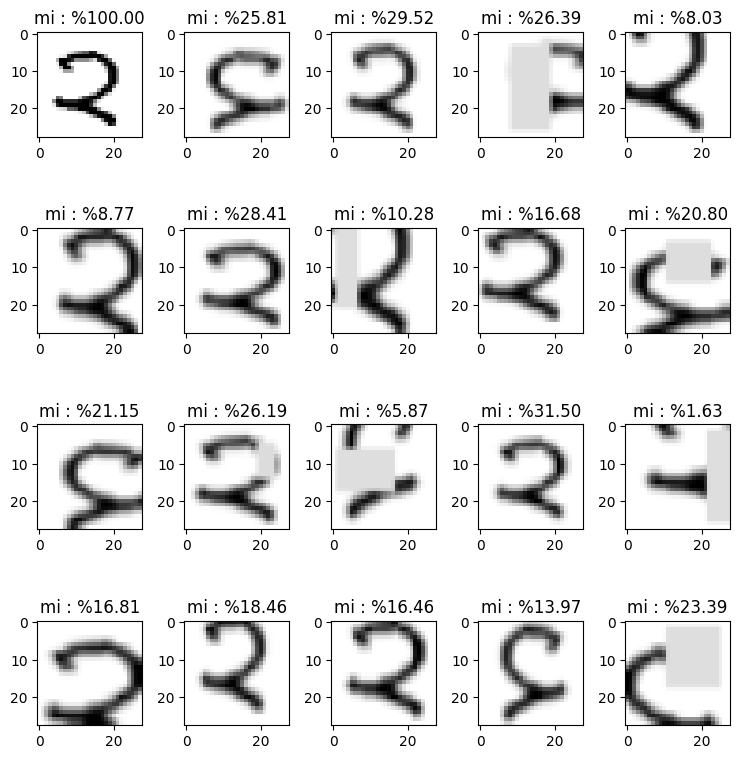


---------------------------------------------------------------------------------------------



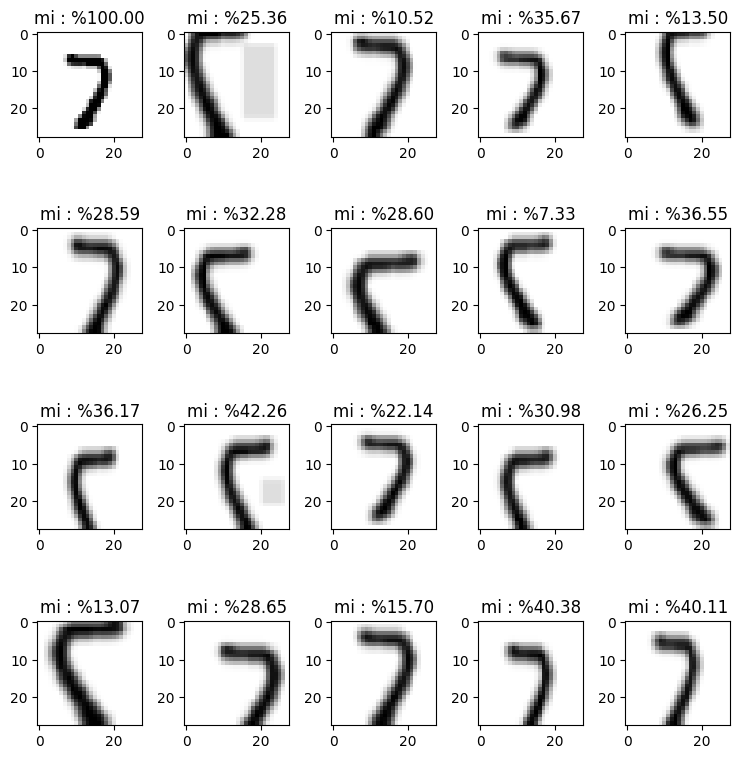


---------------------------------------------------------------------------------------------



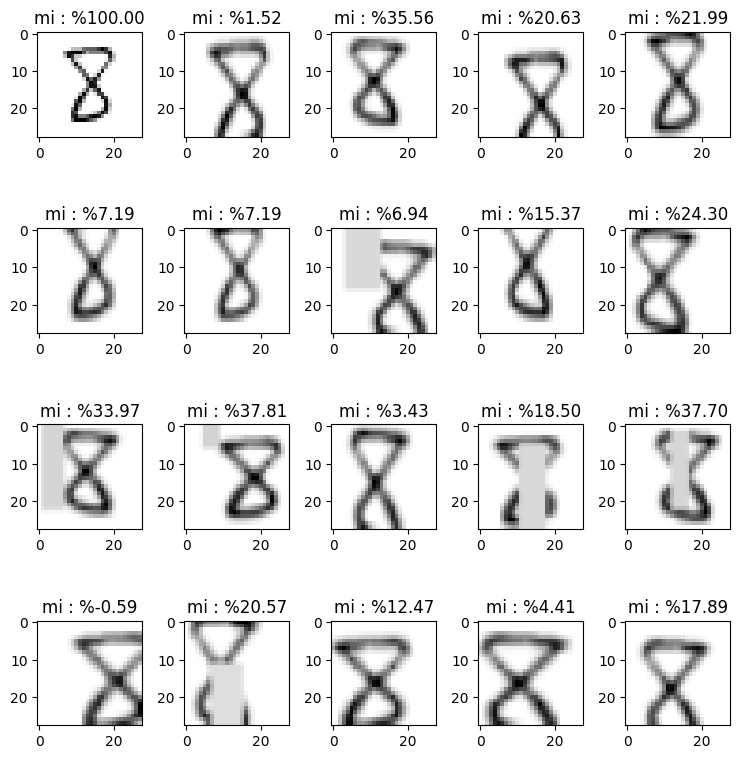


---------------------------------------------------------------------------------------------



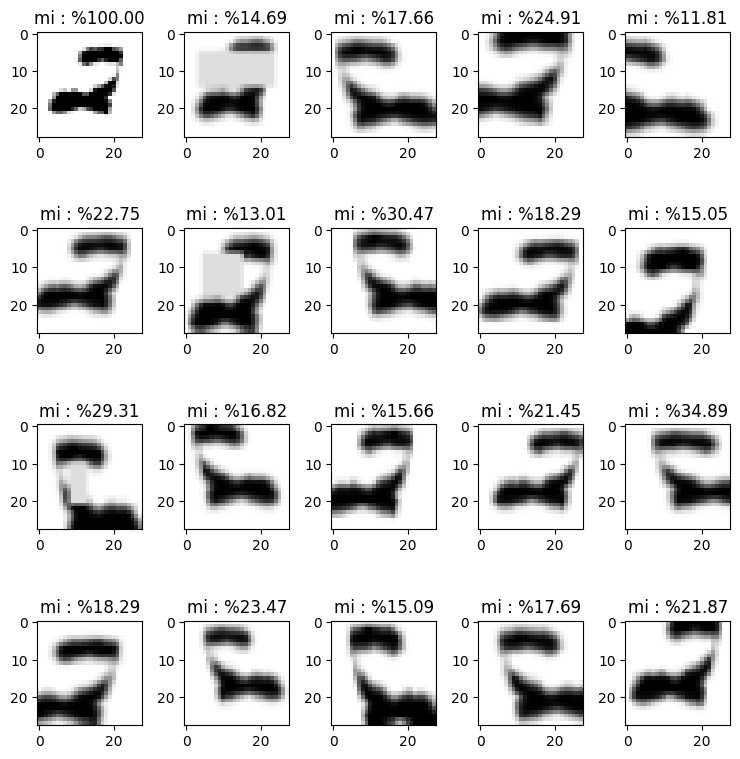


---------------------------------------------------------------------------------------------



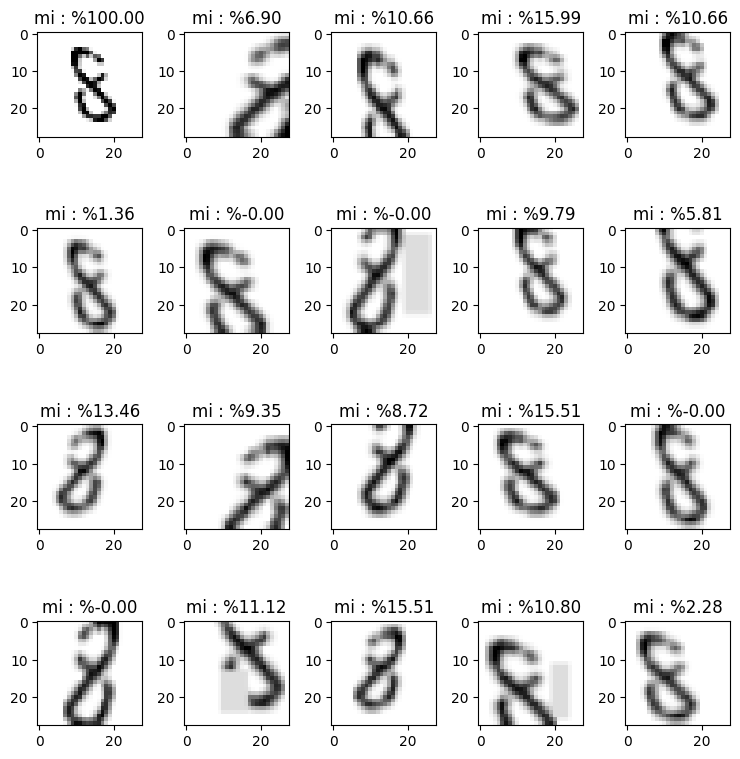


---------------------------------------------------------------------------------------------



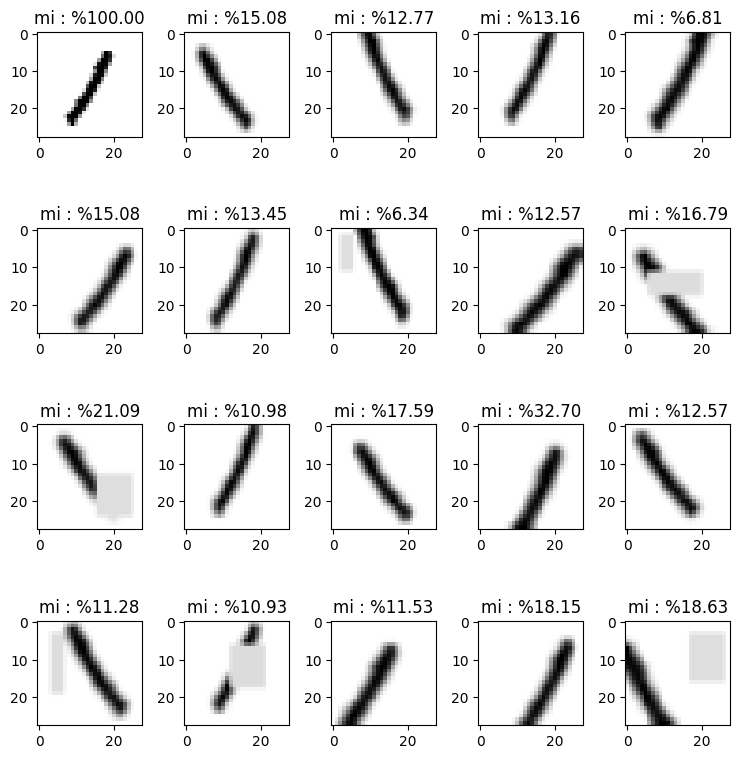


---------------------------------------------------------------------------------------------



In [ ]:
for i in range(len(test_aug_images)):
  test_mi = ["{:.2f}".format(y) for y in test_rnd_mi[i]]
  plot_set_images(4, 5, test_aug_images[i], test_mi, "mi : %")
  print()
  print("---------------------------------------------------------------------------------------------")
  print()